# Onnx vs PyTorch example

This example loads an event inspired by ProtoDUNE-SP simulated data and puts it
through the `DUNEdn` denoising pipeline.

The models implemented in PyTorch are exported to Onnx format and both are used
to make inference separately.

The outputs are then exploited to make accuracy and performance comparisons.

- **Accuracy**  
  Denoised events are analysed against ground truth labels from Monte
  Carlo simulation.  
  Four different metrics (namely `mse`, `psnr`, `ssim` and `iMAE`) are evaluated
  as in the [paper](https://doi.org/10.1007/s41781-021-00077-9).
- **Performance**  
  The elapsed time for PyTorch and Onnx models batch prediction is measured for
  different batch sizes.

In [1]:
from pathlib import Path
import numpy as np
from plot_event_example import plot_example
from assets.functions import check_in_output_folder, inference
from dunedn.inference.hitreco import DnModel
from dunedn.inference.analysis import analysis_main
from dunedn.utils.utils import load_runcard

Define user inputs

In [2]:
modeltype = "uscg"
version = "v08"
pytorch_dev = "cpu"  # device hosting PyTorch computation

Set up the environment

In [3]:
# base folders
base_folder = Path("../../output/tmp")
ckpt_folder = Path(f"../saved_models/{modeltype}_{version}")

# relative folders
folders = {
    "base": base_folder,
    "out": base_folder / "models/onnx",
    "ckpt": ckpt_folder,
    "cards": base_folder / f"cards",
    "onnx_save": base_folder / f"models/onnx/saved_models/{modeltype}_{version}",
    "plot": base_folder / "models/onnx/plots",
    "base_plot": base_folder / "models/onnx/plots/inputs",
    "pytorch_plot": base_folder / "models/onnx/plots/torch",
    "onnx_plot": base_folder / "models/onnx/plots/onnx",
}

check_in_output_folder(folders)

In [4]:
# path to files
paths = {
    "input": folders["out"] / "p2GeV_cosmics_inspired_rawdigit_evt8.npy",
    "target": folders["out"] / "p2GeV_cosmics_inspired_rawdigit_noiseoff_evt8.npy",
    "pytorch": folders["out"]
    / f"p2GeV_cosmics_inspired_rawdigit_torch_{modeltype}_evt8.npy",
    "onnx": folders["out"]
    / f"p2GeV_cosmics_inspired_rawdigit_onnx_{modeltype}_evt8.npy",
}

Plot an example

Saved image at ../../output/tmp/models/onnx/plots/inputs/visual_collection_plane.png


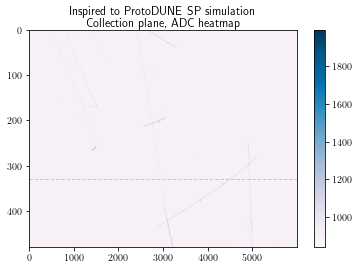

Saved image at ../../output/tmp/models/onnx/plots/inputs/visual_noisy_wire.png


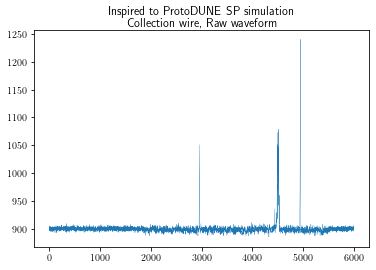

Saved image at ../../output/tmp/models/onnx/plots/inputs/visual_clear_wire.png


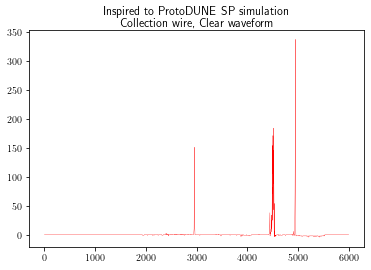

Loaded event at ../../output/tmp/models/onnx/p2GeV_cosmics_inspired_rawdigit_evt8.npy


In [5]:
plot_example(
    paths["input"], paths["target"], outdir=folders["base_plot"], with_graphics=True
)

evt = np.load(paths["input"])[:, 2:]
print(f"Loaded event at {paths['input']}")

## Pytorch inference

### Model loading

In [6]:
setup = load_runcard(base_folder / "cards/runcard.yaml")  # settings
model = DnModel(setup, modeltype, ckpt_folder)
print(f"Loaded model from {ckpt_folder} folder")

[INFO] (dunedn.uscg) Loading weights at ../saved_models/uscg_v08/induction/uscg_v08_dn_induction.pth


RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

### PyTorch inference

In [ ]:
pytorch_time = inference(model, evt, pytorch_dev, paths["pytorch"])
print(f"PyTorch inference done in {pytorch_time}s")

### Analysis: accuracy assessment

In [ ]:
# compute metrics
analysis_main(paths["pytorch"], paths["target"])

In [ ]:
# make plot
plot_example(
    paths["pytorch"],
    paths["target"],
    outdir=folders["pytorch_plot"],
    with_graphics=True,
)

## Onnx inference

### Export to and load model from Onnx format

In [ ]:
# export
model.onnx_export(folders["onnx_save"])

In [ ]:
# load model
model_onnx = DnModel(setup, modeltype, folders["onnx_save"], should_use_onnx=True)

### Onnx inference

In [ ]:
# ONNX inference
onnx_time = inference(model_onnx, evt, paths["onnx"])
print(f"ONNX inference done in {onnx_time}s")

### Analysis: accuracy assessment

In [ ]:
# compute metrics
analysis_main(paths["onnx"], paths["target"])

In [ ]:
# make plot
plot_example(
    paths["onnx"], paths["target"], outdir=folders["onnx_plot"], with_graphics=True
)

### TODO

Batch_size vs inference time plot (PyTorch vs Onnx)